In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import NullFormatter

# read in the shelter occupancy data
# retrieved from https://open.toronto.ca/dataset/covid-19-cases-in-toronto/
df2018 = pd.read_csv('data/shelter_occupancy_2018.csv', usecols=['OCCUPANCY_DATE', 'OCCUPANCY', 'CAPACITY'])
df2019 = pd.read_csv('data/shelter_occupancy_2019.csv', usecols=['OCCUPANCY_DATE', 'OCCUPANCY', 'CAPACITY'])
df2020 = pd.read_csv('data/shelter_occupancy_2020.csv', usecols=['OCCUPANCY_DATE', 'OCCUPANCY', 'CAPACITY'])

def tidy_shelter_df(df):
    """
    Converts date column to datetime, groups and sums data by date, calculates the proportion
    of shelter capacity that is occupied, and makes a column of dates as month and day only.
    """
    df['OCCUPANCY_DATE'] = pd.to_datetime(df['OCCUPANCY_DATE'])
    df = df.groupby(by='OCCUPANCY_DATE').sum().reset_index()
    df['Proportion'] = df['OCCUPANCY'] / df['CAPACITY']
    df['MONTHDAY'] = df['OCCUPANCY_DATE'].dt.strftime('%b %d')
    return df

# tidy up the shelter occupancy data
df2018 = tidy_shelter_df(df2018)
df2018.columns = ['OCCUPANCY_DATE_2018', 'OCCUPANCY_2018', 'CAPACITY_2018', 'Proportion_2018', 'MONTHDAY']
df2019 = tidy_shelter_df(df2019)
df2020 = tidy_shelter_df(df2020)

# read in COVID data
# retrieved from https://open.toronto.ca/dataset/daily-shelter-occupancy/
covid = pd.read_csv('data/COVID19.csv', usecols=['Reported Date', 'Classification'])

# select confirmed cases from 2020, group cases by reported date, and count
covid = covid[covid['Classification'] == 'CONFIRMED']
covid['Reported Date'] = pd.to_datetime(covid['Reported Date'])
covid = covid[(covid['Reported Date'] > '2019-12-31') & (covid['Reported Date'] < '2021-01-01')]
covid = covid.groupby(by='Reported Date').count().reset_index()

# drop Feb 29, add column of dates as month and day only
covid = covid[~((covid['Reported Date'].dt.month == 2) & (covid['Reported Date'].dt.day == 29))]
covid['MONTHDAY'] = covid['Reported Date'].dt.strftime('%b %d')

# merge all the datasets together
data1920 = pd.merge(df2019, df2020, on='MONTHDAY', suffixes=('_2019', '_2020'))
alldata = pd.merge(df2018, data1920, on='MONTHDAY')
alldata = pd.merge(alldata, covid, on='MONTHDAY', how='outer')

alldata = alldata.drop(columns=['Reported Date'])
alldata = alldata.fillna(0)
alldata.head()

,OCCUPANCY_DATE_2018,OCCUPANCY_2018,CAPACITY_2018,Proportion_2018,MONTHDAY,OCCUPANCY_DATE_2019,OCCUPANCY_2019,CAPACITY_2019,Proportion_2019,OCCUPANCY_DATE_2020,OCCUPANCY_2020,CAPACITY_2020,Proportion_2020,Classification
0,2018-01-01,5450,5755,0.947003,Jan 01,2019-01-01,6740,7247.0,0.930040,2020-01-01,6789,7123,0.953110,0.0
1,2018-01-02,5462,5755,0.949088,Jan 02,2019-01-02,6732,7247.0,0.928936,2020-01-02,6764,7123,0.949600,0.0
2,2018-01-03,5479,5755,0.952042,Jan 03,2019-01-03,6707,7247.0,0.925486,2020-01-03,6741,7123,0.946371,0.0
3,2018-01-04,5481,5765,0.950737,Jan 04,2019-01-04,6705,7247.0,0.925210,2020-01-04,6749,7123,0.947494,0.0
4,2018-01-05,5566,5767,0.965147,Jan 05,2019-01-05,6763,7247.0,0.933214,2020-01-05,6729,7123,0.944686,0.0


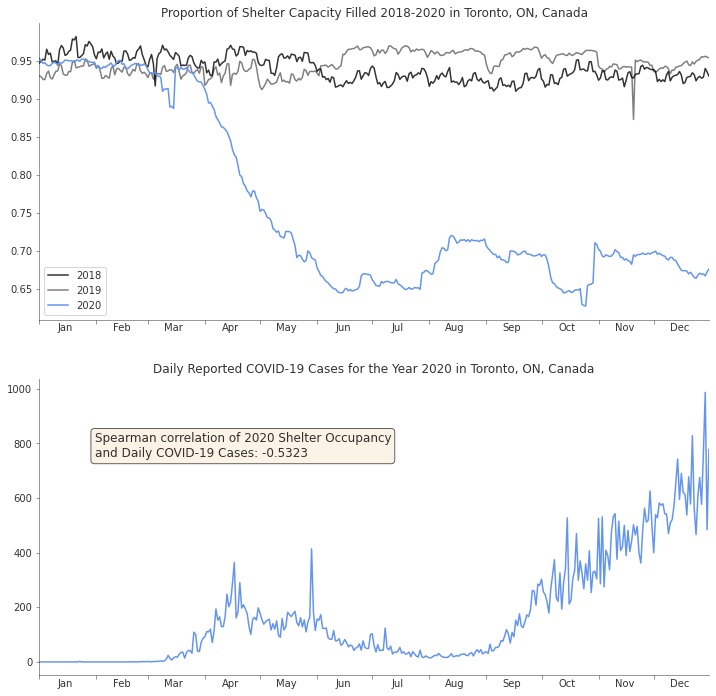

In [2]:
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

# plot the shelter occupancy data
ax1.plot(alldata.index, alldata['Proportion_2018'], 'k', label='2018', alpha=0.8)
ax1.plot(alldata.index, alldata['Proportion_2019'], 'k', label='2019', alpha=0.5)
ax1.plot(alldata.index, alldata['Proportion_2020'], 'cornflowerblue', label='2020')
ax1.set_title('Proportion of Shelter Capacity Filled 2018-2020 in Toronto, ON, Canada', alpha=0.8)
leg = ax1.legend()
for txt in leg.texts:
    txt.set_alpha(0.8)

# plot the covid data and display the correlation
ax2.plot(alldata.index, alldata['Classification'], 'cornflowerblue')
ax2.set_title('Daily Reported COVID-19 Cases for the Year 2020 in Toronto, ON, Canada', alpha=0.8)
sp_corr = alldata['Classification'].corr(alldata['Proportion_2020'], method='spearman')
corr_text = (f'Spearman correlation of 2020 Shelter Occupancy\n'
             f'and Daily COVID-19 Cases: {sp_corr:.4}')
box_props = {'boxstyle': 'round', 'alpha': 0.6, 'facecolor': 'antiquewhite'}
ax2.text(30, 750, corr_text, alpha=0.8, fontsize=12, bbox=box_props)

# x-axis tick handling
first_of_month = MonthLocator()  # monthly ticks
centered_month = MonthLocator(bymonthday=15)  # monthly ticks centered on the middle of the month
date_format = DateFormatter('%b')  # three-letter abbrev. of month

for ax in (ax1, ax2):
    ax.margins(x=0)  # get ride of space on sides of the plots
    x = ax.xaxis
    x.set_major_locator(first_of_month)  # put ticks on the first of the month
    x.set_major_formatter(NullFormatter())  # hide labels of major ticks
    x.set_minor_locator(centered_month)  # make centered minor ticks
    x.set_minor_formatter(date_format)  # center month labels
    ax.tick_params(axis='x', which='minor', length=0) # hide minor ticks
    ax.tick_params(axis=u'both', which=u'both', color=[0, 0, 0, 0.5])  # reduce alpha of ticks
    plt.setp(ax.get_xminorticklabels(), alpha=0.8)
    plt.setp(ax.get_yticklabels(), alpha=0.8)
    
    # adjust spine visibility and alpha
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_alpha(0.5)

In [3]:
fig.savefig('Covid-and-Shelters.jpg')